## Seismic: an array of numbers (answers)

In [1]:
from IPython.display import Math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import time
start = time.time()
 
data = np.loadtxt('data/F3_3x3.txt')
 
end = time.time()
elapsed = end - start
print("Time taken to read volume: {:.2f} seconds.".format(elapsed))

Time taken to read volume: 34.95 seconds.


In [3]:
# Need to know:
nIL = 194  # number of inlines
nXL = 299  # number of crosslines
nt = 463   # number of samples per trace
dt = 0.004 # sample rate in seconds

volume = np.reshape(data, newshape = (nIL, nXL, nt))
print(volume.shape)

(194, 299, 463)


----
**Exercise**: Get rid of some bad data for the last few samples on each trace.

In [4]:
volume = volume[:,:,:450]
print(volume.shape)

(194, 299, 450)


Load a pre-selected crossline from the volume

In [5]:
XL = 50
line = volume[XL,:, : ]
print('crossline {} has {} traces and {} samples/trace.'.format(XL, line.shape[0], line.shape[1]))

crossline 50 has 299 traces and 450 samples/trace.


In [6]:
# find the middle trace on this line
x = line.shape[0]/2
print('The middle trace on XL {} is in position {}.'.format(XL, x))

The middle trace on XL 50 is in position 149.5.


In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
#take the middle trace, 's' out of the array (at location x):

s = line[x,:]

print ("the number of samples on this trace is:", len(s))

# find the max value along the trace
biggest = np.amax(s)
print ("Max value: ", biggest)
print ("located in element: ", np.where(s==biggest), '\n')

# find the minimum value along the trace
smallest = np.amin(s)
print ("Min value: ", smallest)
print ("located in element: ", np.where(s==smallest), '\n')

# find the peak to peak range of the trace
amp_range = s.ptp()
print ("Peak to peak: ", amp_range)

# check to see that the mean of the trace is close to zero
trace_mean = s.mean()
print ("Mean value: ", trace_mean)

the number of samples on this trace is: 450
Max value:  11405.0
located in element:  (array([447]),) 

Min value:  -16408.0
located in element:  (array([427]),) 

Peak to peak:  27813.0
Mean value:  4.38444444444


## Plot a seismic trace

In [9]:
# make a time axis
t_min = 0.0
t_max = 1.800
dt = 0.004
t = np.arange(t_min, t_max, step = dt)

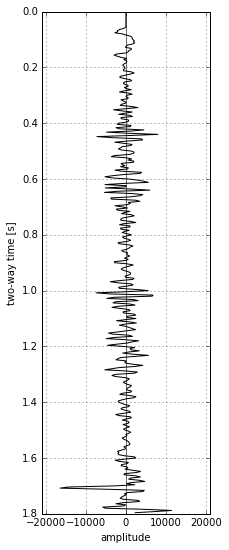

In [10]:
fig1 = plt.figure(figsize = (3,9), facecolor='white')
ax1 = fig1.add_subplot(111)
wigplt = ax1.plot(s, t,'k')

"""Maybe want to come back and make a function of this below"""

# plot the zero-crossing
vmin = -0.75*s.ptp() # make axis 50% larger than max/min of trace
vmax = 0.75*s.ptp()

# plot zero-crossing
zerocrossing = ax1.plot(np.zeros_like(s), t,'k', alpha=0.5)
ax1.set_xlim( (vmin, vmax) )
ax1.set_ylabel('two-way time [s]')
ax1.set_xlabel('amplitude')
ax1.invert_yaxis()
ax1.grid()

## Trace statistics

Let's look at a histogram of the values along this trace

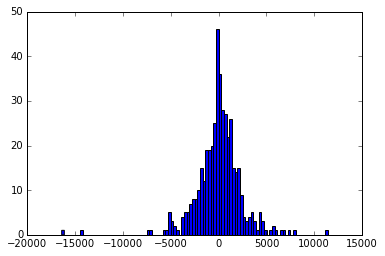

In [11]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.hist(s, bins=100)
plt.show()

As suspected, most of the data values are close to zero, and fan outward (more or less symmetrically) to larger positive and negative values.

To be sure, we can include the values from the entire line to build up better statitics. However, in order to pass a 2D array to the <code>plt.hist</code> function, we have to unravel it first,

In [12]:
line = volume[50,...]
vmin = -0.2 * line.ptp()
vmax = 0.2 * line.ptp()

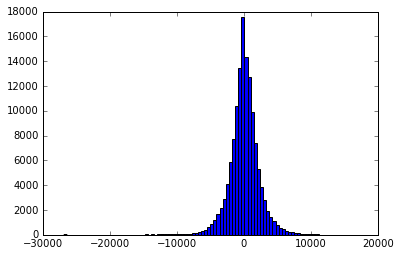

In [13]:
fig3 = plt.figure()
hist_ax = fig3.add_subplot(111)
hist_line = hist_ax.hist(np.ravel(line), bins=100)
fig3.show()

There, that looks like it should for seismic data.

## Trace bandwidth

Let's look at the frequency content of this trace. To do this we will need to use the the fast fourier transform function from the Scipy FFT module. It helps to know that the sample rate of the trace is 0.04 s

In [14]:
from scipy import fft
S = abs(fft(s))
faxis = np.fft.fftfreq( len(s), d = dt)

Plot it on a log base 10 scale (Decibel)

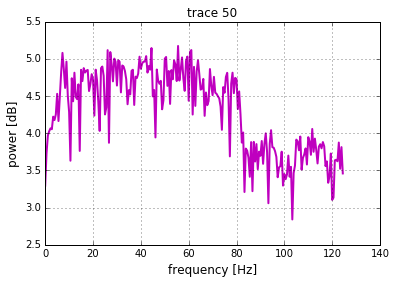

In [15]:
plt.plot(faxis[:len(faxis)//2], np.log10(S[0:len(faxis)//2]),'m', lw=2)
plt.xlabel('frequency [Hz]', fontsize=12)
plt.ylabel('power [dB]', fontsize=12)
plt.title('trace %i' %XL) # format code for integer string replacement
plt.grid()

Let's look at the power spectra for all the lines as an ensemble,

In [16]:
ntraces = line.shape[0]
Ss = np.zeros_like(S)
for trace in np.rollaxis(line,0,1):
    Ss += abs(fft(trace))                
Ss /= ntraces

Make plot again on a decibel scale with all traces

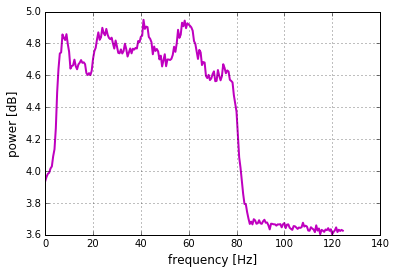

In [17]:
plt.plot(faxis[:len(faxis)//2], np.log10(Ss[0:len(faxis)//2]),'m', lw=2)
plt.xlabel('frequency [Hz]', fontsize=12)
plt.ylabel('power [dB]', fontsize=12)
plt.grid()

## Plot the entire line

In [18]:
line_ext = {'first_trace': 1, 
            'last_trace': line.shape[0], 
            'start_time': t[0], 
            'end_time':t[-1] 
            }
line_ext

{'end_time': 1.796, 'first_trace': 1, 'last_trace': 299, 'start_time': 0.0}

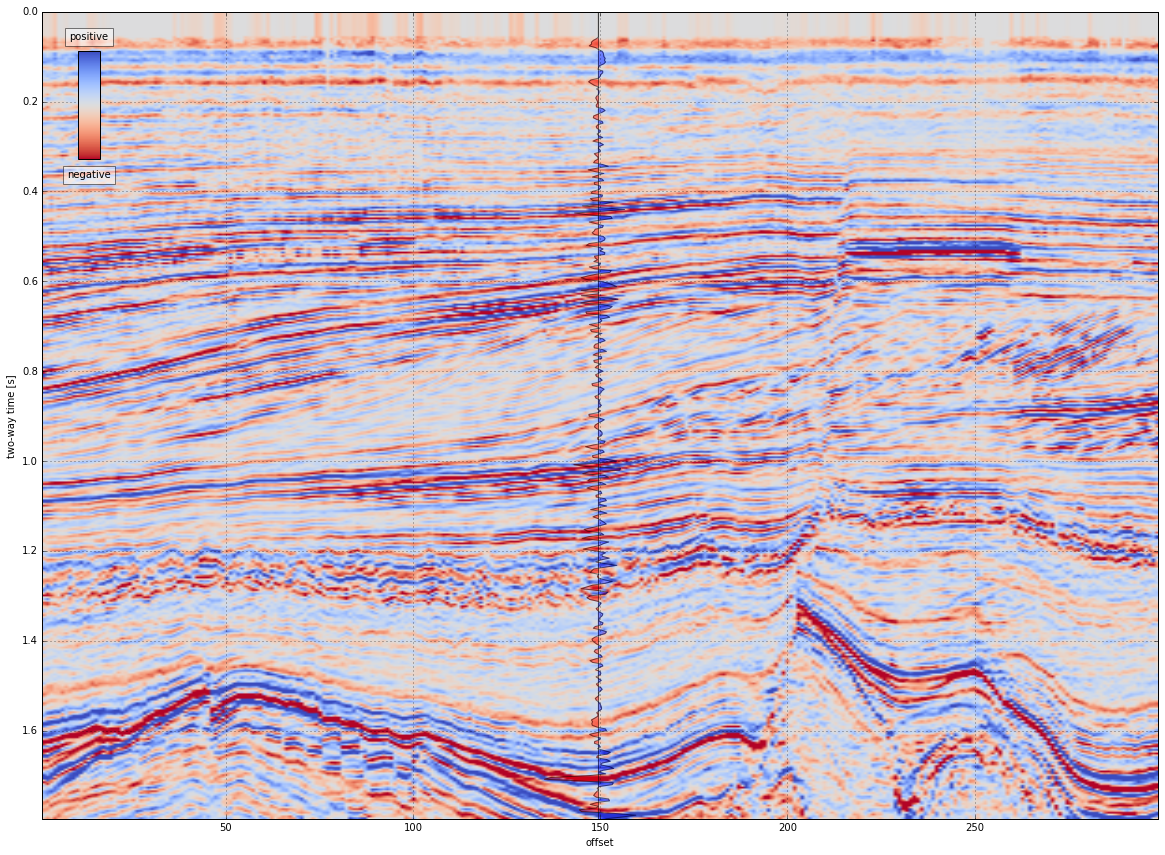

In [19]:
figline = plt.figure(figsize = (20, 15), facecolor='white')
ax = figline.add_subplot(111)
imline = np.transpose(line)   # <--- must tranpose for image orientation

### PLOT THE SEISMIC ###
im = ax.imshow(imline, cmap='coolwarm_r', vmin = vmin*0.5, vmax = vmax*0.5,
               extent =  (line_ext['first_trace'], 
                          line_ext['last_trace'], 
                          line_ext['end_time'], 
                          line_ext['start_time']), 
               aspect = 120)
   
### PLOT THE TRACE ###
ax.plot(x + 10*(s/np.amax(s)), t,'k', alpha = 0.5)
# plot positive values in wiggle trace blue
ax.fill_betweenx( y = t, 
                  x1 = x + 10.0*(s/np.amax(s)), 
                  x2 = x,
                  where = s > 0,
                  alpha = 0.35,
                  color = 'b')
# plot negative values in wiggle trace red
ax.fill_betweenx( y = t, 
                  x1 = x + 10.0*(s/np.amax(s)), 
                  x2 = x, 
                  where = s < 0,
                  alpha = 0.35,
                  color = 'r')
                      
# plot zero-crossing of the trace
ax.plot(x*np.ones_like(s), t, 'k', alpha = 0.5)

### Create a colorbar axes ###
colorbar_ax = figline.add_axes([0.15, 0.75, 0.015, 0.1])
# assign the im ScalarMappable to the colorbar
figline.colorbar(im, cax=colorbar_ax)
# put text on the colorbar for the bottom
colorbar_ax.text( 0.5, -0.1, 'negative', bbox=dict(facecolor='white', alpha=0.5),
                      transform=colorbar_ax.transAxes,
                      horizontalalignment='center',
                      verticalalignment='top')
# put text on the colorbar for the bottom
colorbar_ax.text( 0.5, 1.1, 'positive',
                     transform=colorbar_ax.transAxes, bbox=dict(facecolor='white', alpha=0.5),
                     horizontalalignment='center')
# turn off the colorbar ticks
colorbar_ax.set_axis_off()

# labels and grids
ax.set_xlim(left = line_ext['first_trace'], right = line_ext['last_trace'])
ax.set_xlabel('offset')
ax.set_ylim(bottom = line_ext['end_time'], top = line_ext['start_time'])
ax.set_ylabel('two-way time [s]')
ax.grid()